In [53]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import rich 
console = rich.get_console()
console.width = 80

In [55]:
import jax.numpy as jnp
import flax.linen as nn

from stanza.nets.mlp import MLP

mlp = MLP([32, 16, 10, 1])

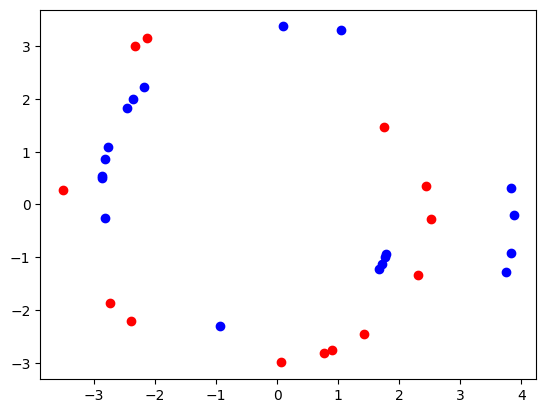

In [56]:
import jax
from stanza.data import Data
import matplotlib.pyplot as plt

def generate_data(rng_key):
    t = jax.random.uniform(rng_key)
    y = jax.random.choice(rng_key, jnp.array([0,1]), replace=False)
    r = 2*(1 + t)
    o = 2*y
    x1 = r*jnp.sin(2 * jnp.pi * t + o)
    x2 = r*jnp.cos(2 * jnp.pi * t + o)
    # x1 = t
    # x2 = y
    X = jnp.stack([x1, x2])
    return X, y

data = jax.vmap(generate_data)(jax.random.split(jax.random.PRNGKey(42), 32))
val_data = jax.vmap(generate_data)(jax.random.split(jax.random.PRNGKey(44), 128))
data = Data.from_pytree(data)
val_data = Data.from_pytree(val_data)

def plot_data(ax, d):
    d = d.data
    X, y = d
    X0 = X[y==0,:]
    X1 = X[y==1,:]
    x0, y0 = X0[:,0], X0[:,1]
    x1, y1 = X1[:,0], X1[:,1]
    ax.plot(x0, y0, 'o', color='red')
    ax.plot(x1, y1, 'o', color='blue')
plot_data(plt.gca(), data)
#plot_data(plt.gca(), val_data)
plt.show()

In [57]:
from stanza.nets.mlp import MLP
import optax
import jax.flatten_util

mlp = MLP([64, 32, 10, 1], "gelu")

def model(params, x):
    pred = mlp.apply(params, x)
    return jax.nn.sigmoid(pred)

def loss(state, params, rng, batch, noise=0.):
    X, y = batch
    if noise > 0:
        label_noise = noise*jax.random.uniform(rng, shape=y.shape, minval=-1., maxval=1.)
        y = y + label_noise
        y = jnp.clip(y, 0., 1.)
    y_pred = jax.vmap(mlp.apply, in_axes=(None, 0))(params, X).squeeze()
    loss = optax.sigmoid_binary_cross_entropy(y_pred, y).mean()
    # y_pred = jax.nn.sigmoid(y_pred)
    # loss = jnp.square(y_pred - y).mean()
    return state, loss, {"loss": loss}

def singular_values(params):
    params_flat, params_uf = jax.flatten_util.ravel_pytree(params)
    def flat_loss(params_flat):
        params = params_uf(params_flat)
        return loss(None, params, jax.random.PRNGKey(42), data.data)[1]
    H = jax.hessian(flat_loss)(params_flat)
    s = jnp.linalg.svd(H, compute_uv=False)
    t = jnp.trace(H)
    #s = s[s > 1e-6]
    return s, t

def accuracy(params, data):
    X, y = data.data
    y_pred = jax.vmap(model, in_axes=(None, 0))(params, X).squeeze()
    y_pred = jnp.round(y_pred)
    return (y_pred == y).mean()

In [58]:
from stanza.train import Trainer, SAMTrainer
from stanza.util.rich import ConsoleDisplay, StatisticsTable, LoopProgress
from stanza import partial
from jax.random import PRNGKey
import optax

def train(data, noise=0.):
    loss_fn = partial(loss, noise=noise)
    display = ConsoleDisplay()
    display.add("train", StatisticsTable(), interval=100)
    display.add("train", LoopProgress(), interval=100)
    trainer = Trainer(
        loss_fn=loss_fn, 
        max_iterations=30_000,
        batch_size=16
    )

    with display as dh:
        init_params = mlp.init(PRNGKey(42), jnp.ones((2,)))
        results = trainer.train(data,
            rng_key=PRNGKey(43),
            init_params=init_params,
            train_hooks=[dh.train]
        )
    return results.fn_params

def train_sam(data, noise=0.):
    loss_fn = partial(loss, noise=noise)
    display = ConsoleDisplay()
    display.add("train", StatisticsTable(), interval=100)
    display.add("train", LoopProgress(), interval=100)
    trainer = SAMTrainer(
        loss_fn=loss_fn, 
        max_iterations=30_000, batch_size=16,
        sub_optimizer=optax.scale(5e-2)
    )

    with display as dh:
        init_params = mlp.init(PRNGKey(42), jnp.ones((2,)))
        results = trainer.train(data, rng_key=PRNGKey(43), init_params=init_params, train_hooks=[dh.train])
    return results.fn_params

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcol

def visualize_model(ax, params):
    X, _ = data.data
    # x_min, x_max = jnp.min(X[:,0]), jnp.max(X[:,0])
    # y_min, y_max = jnp.min(X[:,1]), jnp.max(X[:,1])
    x_min, x_max = -4, 4
    y_min, y_max = -4, 4
    x, y = jnp.meshgrid(
        jnp.linspace(x_min, x_max, 40),
        jnp.linspace(y_min, y_max, 40)
    )
    X = jnp.stack([x.flatten(), y.flatten()], axis=-1)
    y_pred = jax.vmap(model, in_axes=(None, 0))(params, X)
    y_pred = y_pred.reshape(x.shape)
    cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",[(0.4, 0., 0.),(0., 0., 0.4)])
    ax.pcolor(x, y, y_pred, cmap=cmap, vmin=0, vmax=1)
    ax.contour(x, y, y_pred, levels=[0.5], colors='k')


In [60]:
params = train(data)

Output()

[15:53:56] TRACE  - <Tracing> Tracing training                   ]8;id=671999;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=921324;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#122\122]8;;\

           TRACE  - <Tracing> Tracing epoch step                 ]8;id=364123;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=533774;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#104\104]8;;\

           TRACE  - <Tracing> Tracing train step                  ]8;id=191257;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=555175;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#69\69]8;;\

           TRACE  - <Tracing> Done tracing training              ]8;id=997907;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=936996;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#131\131]8;;\

In [61]:
sam_params = train_sam(data)

Output()

[15:54:38] TRACE  - <Tracing> Tracing training                   ]8;id=360997;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=948458;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#122\122]8;;\

           TRACE  - <Tracing> Tracing epoch step                 ]8;id=421859;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=992846;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#104\104]8;;\

           TRACE  - <Tracing> Tracing train step                 ]8;id=133250;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=241277;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#222\222]8;;\

           TRACE  - <Tracing> Done tracing training              ]8;id=608334;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=986140;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#131\131]8;;\

In [62]:
noisy_params = train(data, noise=1e-5)

Output()

[15:55:20] TRACE  - <Tracing> Tracing training                   ]8;id=375875;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=28602;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#122\122]8;;\

           TRACE  - <Tracing> Tracing epoch step                 ]8;id=614280;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=470679;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#104\104]8;;\

           TRACE  - <Tracing> Tracing train step                  ]8;id=361531;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=8187;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#69\69]8;;\

[15:55:21] TRACE  - <Tracing> Done tracing training              ]8;id=237339;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=539987;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#131\131]8;;\

In [63]:
noisy_sam_params = train_sam(data, noise=1e-5)

Output()

[15:56:04] TRACE  - <Tracing> Tracing training                   ]8;id=516068;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=356087;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#122\122]8;;\

           TRACE  - <Tracing> Tracing epoch step                 ]8;id=149017;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=79005;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#104\104]8;;\

           TRACE  - <Tracing> Tracing train step                 ]8;id=794838;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=106489;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#222\222]8;;\

           TRACE  - <Tracing> Done tracing training              ]8;id=832291;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py\__init__.py]8;;\:]8;id=514016;file:///home/daniel/Documents/code/stable_imitation/stanza/stanza/train/__init__.py#131\131]8;;\

0.6484375
0.6171875
0.71875
0.65625


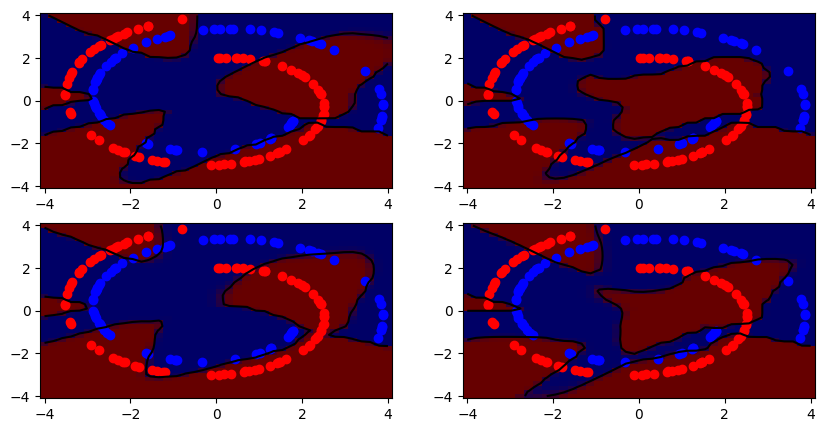

In [64]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,5))
for ax, p in zip([ax1, ax2, ax3, ax4], [params, sam_params, 
                                             noisy_params, noisy_sam_params]):
    plot_data(ax, data)
    plot_data(ax, val_data)
    visualize_model(ax, p)
    print(accuracy(p, val_data))
plt.show()

2.0256992e-07
0.00016134293
0.009310895
0.0080981525


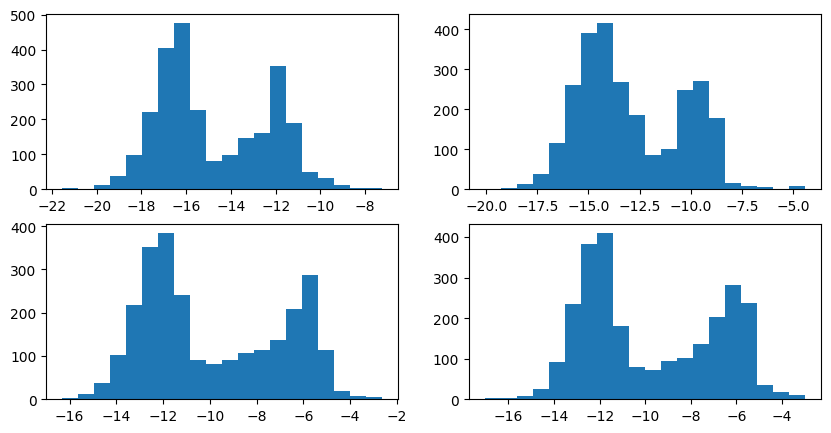

In [66]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,5))
for ax, p in zip([ax1, ax2, ax3, ax4], [params, sam_params, 
                                             noisy_params, noisy_sam_params]):
    s, trace = singular_values(p)
    ax.hist(jnp.log(s)/jnp.log(10), bins=20)
    print(trace)
plt.show()